# Load packages

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from collections import OrderedDict
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from Algorithm.CNN_With_Tm import Predefined_CNN
from Algorithm.FCNet_With_Tm import Predefined_FCNet
from Algorithm.FCNet_Unbiased import Predefined_FCNet_Unbiased
from Algorithm.CNN_Unbiased import Predefined_CNN_Unbiased
from Algorithm.FCNet_Without_Tm import Predefined_FCNet_Without_Tm
from Algorithm.CNN_Without_Tm import Predefined_CNN_Without_Tm
from Algorithm.FCNet_CIFAR import Predefined_FCNet_CIFAR
from Algorithm.CNN_CIFAR import Predefined_CNN_CIFAR

# Load data

In [2]:
def load_data(filename):
    dataset = np.load ("data/" + filename + ".npz")
    Xtr_val = dataset['Xtr']
    Str_val = dataset['Str']
    Xts = dataset['Xts']
    Yts = dataset['Yts']
    
    return Xtr_val, Str_val, Xts, Yts

# check gpu

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data visualisation

## FashionMNIST0.5

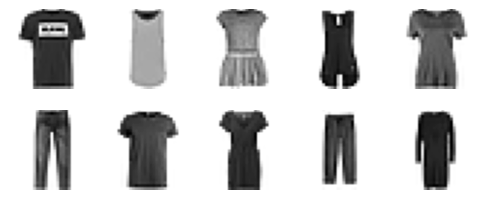

The classes in this dataset are {0, 1, 2}.


In [4]:
train_data_m5, train_label_m5, test_data_m5, test_label_m5 = load_data("FashionMNIST0.5")

def plot_dataset(data, n_rows=2, n_cols=5):
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
 
    for row in range(n_rows):
        for col in range(n_cols):
 
            # Get next index of image
            index = n_cols * row + col
 
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index].reshape(28,28), cmap="binary")
            plt.axis('off')
 
    plt.show()
plot_dataset(train_data_m5)
print("The classes in this dataset are {}.".format(set(train_label_m5)))

## FashionMNIST0.6

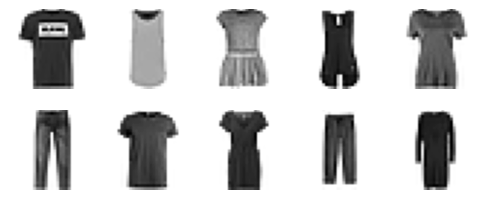

The classes in this dataset are {0, 1, 2}.


In [5]:
train_data_m6, train_label_m6, test_data_m6, test_label_m6 = load_data("FashionMNIST0.6")

def plot_dataset(data, n_rows=2, n_cols=5):
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
 
    for row in range(n_rows):
        for col in range(n_cols):
 
            # Get next index of image
            index = n_cols * row + col
 
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index].reshape(28,28), cmap="binary")
            plt.axis('off')
 
    plt.show()
plot_dataset(train_data_m6)
print("The classes in this dataset are {}.".format(set(train_label_m6)))

## CIFAR

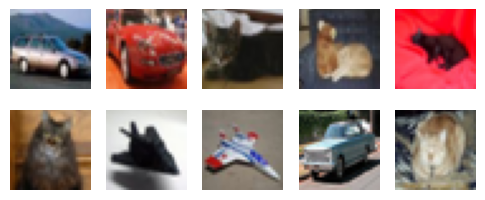

The classes in this dataset are {0, 1, 2}.


In [6]:
train_data_c, train_label_c, test_data_c, test_label_c = load_data("CIFAR")

def plot_dataset(data, n_rows=2, n_cols=5):
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
 
    for row in range(n_rows):
        for col in range(n_cols):
 
            # Get next index of image
            index = n_cols * row + col
 
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index].reshape(32,32,3), cmap="binary")
            plt.axis('off')
 
    plt.show()
plot_dataset(train_data_c)
print("The classes in this dataset are {}.".format(set(train_label_c)))

# Define Functions 

## Function for noisy data preprocessing

In [7]:
class DatasetArray(Dataset):
    def __init__(self, data, labels):
        # Normalisation
        self.data_arr = np.asarray(data).astype(np.float32) / 255
        # add a extra channel dim
        if len(self.data_arr.shape) == 3:
            self.data_arr= np.expand_dims(self.data_arr, 1)
        elif len(self.data_arr.shape) == 4:
            self.data_arr = self.data_arr.transpose((0, 3, 1, 2)) 
        self.label_arr = np.asarray(labels).astype(np.int64)
        
    def __len__(self):
        return len(self.data_arr)
    
    def __getitem__(self, index):
     
        data = self.data_arr[index]
        label = self.label_arr[index]

            
        return (data, label)

def get_loader(batch_size = 100, num_workers = 1, train_val_test_split = 0.8, data = None):
    X_val, y_val, X_test, y_test = load_data(data)
    X_train, X_valid, y_train, y_valid = train_test_split(X_val, y_val, train_size = train_val_test_split)
    train_data = DatasetArray(X_train, y_train)
    val_data = DatasetArray(X_valid, y_valid)
    test_data = DatasetArray(X_test, y_test)

    #The pytorch built-in class DataLoader can help us to shuffle the data, draw mini-batch,
    #do transformations, etc. 
    train_loader = DataLoader(
        dataset=train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
    )

    val_loader = DataLoader(
        dataset=val_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )

    test_loader = DataLoader(
        dataset=test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0,
    )
    return train_loader, val_loader, test_loader

## Functions for training and validation

In [8]:
def Average(lst): 
    return sum(lst) / len(lst)

def seed_torch(seed=1029):  
    # Python's built-in random library
    random.seed(seed)
    
    # Python's hash seed for deterministic hashing (used in some specific operations)
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    # NumPy's random library
    np.random.seed(seed)
    
    # PyTorch's random seed for CPU and GPU tensors
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
    # If multiple GPUs are being used
    torch.cuda.manual_seed_all(seed)
    
    # Ensuring deterministic behavior in CUDA operations (might affect performance)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

# Calcuate the accuracy according to the prediction and the true label.
def accuracy(output, target, topk=(1,)):
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, num):
        self.val = val
        self.sum += val * num
        self.count += num
        self.avg = self.sum / self.count


def load_model(m_config):
    # The 'globals()' function returns the dictionary of the current global symbol table.
    # We use it here to call the class constructor based on the string name provided in 'm_config'.
    model = globals()[m_config['model_name']](
        transition_matrix = m_config["transition_matrix"]
    )
    return model
def load_model_without_tm(m_config):
    model = globals()[m_config['model_name']]()
    return model

## Functions for unbiased estimator

In [9]:
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, noise_rate):
        super(CustomCrossEntropyLoss, self).__init__()
        self.noise_rate = noise_rate
        self.ce_loss = nn.CrossEntropyLoss()
        
    def forward(self, outputs, targets):
        loss = self.ce_loss(outputs, targets)
        corrected_loss = loss / (1 - self.noise_rate)
        return corrected_loss


## Functions for train,validation and test

In [10]:
def train(epoch, model, optimizer, criterion, train_loader, device):
    """Training a pytorch resnet_model."""
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()

    # swith model to to train mode
    model.train()
    for step, (data, targets) in enumerate(train_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)

        
        # predict
        preds = model(data)
        # forward
        loss = criterion(preds, targets)

        # set all gradients to zero
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update all gradients
        optimizer.step()

        # calculate accuracy
        [top1_accuracy] = accuracy(preds.data, targets.data, topk=(1,))
        # record accuary and cross entropy losss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_accuracy.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

        top1_acc_avg = top1_acc_meter.avg
    return top1_acc_avg


def validate_and_test(epoch, model, criterion, val_loader, device, test = False):
    """Validation or testing of an nn_model."""
    top1_acc_meter = AverageMeter()
    loss_meter = AverageMeter()
    precision_meter = AverageMeter()
    recall_meter = AverageMeter()
    f1_meter = AverageMeter()

    # switch model to eval mode
    model.eval()
    for step, (data, targets) in enumerate(val_loader):
        # prepare min_batch
        data = data.to(device)
        targets = targets.to(device)
        # predict
        with torch.no_grad():
            preds = model(data)

        # forward
        loss = criterion(preds, targets)

        # calculate accuracy
        [top1_accuracy] = accuracy(preds.data, targets.data, topk=(1,))

        # record accuracy and cross-entropy loss
        min_batch_size = data.size(0)
        top1_acc_meter.update(top1_accuracy.item(), min_batch_size)
        loss_meter.update(loss.item(), min_batch_size)

        # Calculate precision and recall on CPU
        preds_classes = preds.argmax(dim=1).cpu().numpy()
        targets_cpu = targets.cpu().numpy()

        precision = precision_score(targets_cpu, preds_classes, average='macro', zero_division=1)
        recall = recall_score(targets_cpu, preds_classes, average='macro')
        f1 = f1_score(targets_cpu, preds_classes, average='macro')

        precision_meter.update(precision, min_batch_size)
        recall_meter.update(recall, min_batch_size)
        f1_meter.update(f1, min_batch_size)

    top1_acc_avg = top1_acc_meter.avg
    precision_avg = precision_meter.avg
    recall_avg = recall_meter.avg
    f1_avg = f1_meter.avg
    
    return top1_acc_avg, precision_avg, recall_avg, f1_avg


## Function for Label noise methods with known flip rates (Reweighting)

In [11]:

# Some global variabiles
device = None
train_loader = None
model = None

# Run the train data
def run_train_val():
    global device, config, train_loader, model
    best_top1_acc = 0  # Keep track of the best accuracy so far

    # Check if a GPU is available and set the device accordingly
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Extract specific configurations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']

    # Set all random seeds for deterministic behavior
    seed_torch(run_config['seed'])

    # Create output directory if it doesn't exist
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    
    
    train_acc_list=[]
    valid_acc_list=[]
    test_acc_list=[]
    precision_list=[]
    recall_list=[]
    f1_list=[]

    acc_tl = []
    top1_acc_vl = []
    test_acc_vl = []
    precision_vl = []
    recall_vl = []
    f1_vl = []

    i=0
    while i<10:

        # Get training, validation, and testing data loaders
        train_loader, val_loader, test_loader = get_loader(
            batch_size=optim_config['batch_size'],
            num_workers=run_config['num_workers'],
            train_val_test_split=data_config['training_pct'],
            data = data_config['data_path']
        )

        # Load the specified model
        model = load_model(config['model_config'])

        # If multiple GPUs are available, use them
        if torch.cuda.device_count() > 1:
            print(torch.cuda.device_count(), "GPUs are used!")
            model = nn.DataParallel(model)
        model.to(device)

        # Specify loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.SGD(
            params=model.parameters(),
            lr=optim_config['base_lr'],
            momentum=optim_config['momentum'],
            weight_decay=optim_config['weight_decay']
        )

        # Training loop
        for epoch in range(1, optim_config['epochs'] + 1):
            # Train model for one epoch
            train_acc = train(epoch, model, optimizer, criterion, train_loader, device)
            acc_tl.append(train_acc)

            # Validate the model
            top1_acc_avg, precision_avg, recall_avg, f1_avg = validate_and_test(epoch, model, criterion, val_loader, device, test = False)
            test_acc_avg, precision_avg, recall_avg, f1_avg=validate_and_test(epoch, model, criterion, test_loader, device, test = True)
            top1_acc_vl.append(top1_acc_avg)
            test_acc_vl.append(test_acc_avg)
            precision_vl.append(precision_avg)
            recall_vl.append(recall_avg)
            f1_vl.append(f1_avg)

            # Save the best performing model based on validation accuracy
            if top1_acc_avg > best_top1_acc:
                state = OrderedDict([
                    ('config', config),
                    ('state_dict', model.state_dict()),
                    ('optimizer', optimizer.state_dict()),
                    ('epoch', epoch),
                    ('top1-accuracy', top1_acc_avg),
                ])
                best_model_path = os.path.join(outdir, 'model_best.pth')
                torch.save(state, best_model_path)
                best_top1_acc = top1_acc_avg
        test_acc_avg, precision_avg, recall_avg, f1_avg=validate_and_test(epoch, model, criterion, test_loader, device, test = True)
        train_acc_list.append(train_acc)
        valid_acc_list.append(best_top1_acc)
        test_acc_list.append(test_acc_avg)
        precision_list.append(precision_avg)
        recall_list.append(recall_avg)
        f1_list.append(f1_avg)
        i+=1
    print("Top 1 Train Accuracy:      Mean = {:.2f}, Std Dev = {:.2f}".format(Average(train_acc_list), np.std(train_acc_list)))
    print("Top 1 Validate Accuracy:   Mean = {:.2f}, Std Dev = {:.2f}".format(Average(valid_acc_list), np.std(valid_acc_list)))
    print("Top 1 Test Accuracy:       Mean = {:.2f}, Std Dev = {:.2f}".format(Average(test_acc_list), np.std(test_acc_list)))
    print("Precision:                 Mean = {:.2f}, Std Dev = {:.5f}".format(Average(precision_list), np.std(precision_list)))
    print("Recall:                    Mean = {:.2f}, Std Dev = {:.5f}".format(Average(recall_list), np.std(recall_list)))
    print("F1 Score:                  Mean = {:.2f}, Std Dev = {:.5f}".format(Average(f1_list), np.std(f1_list)))

    return acc_tl, top1_acc_vl, test_acc_vl, precision_vl, recall_vl, f1_vl       



## Function for Label noise methods with unknown flip rates (Calulate TM )

In [12]:
# Some global variabiles
device = None
train_loader = None
model = None




# Run the train data
def run_tm_val():
    global device, config, train_loader, model
    
    best_top1_acc = 0  # Keep track of the best accuracy so far

    # Check if a GPU is available and set the device accordingly
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Extract specific configurations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']

    # Set all random seeds for deterministic behavior
    seed_torch(run_config['seed'])

    # Create output directory if it doesn't exist
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    
    # Get training, validation, and testing data loaders
    train_loader, val_loader, test_loader = get_loader(
        batch_size=optim_config['batch_size'],
        num_workers=run_config['num_workers'],
        train_val_test_split=data_config['training_pct'],
        data = data_config['data_path']
    )

    # Load the specified model
    model = load_model_without_tm(config['model_config'])
    # If multiple GPUs are available, use them

    model.to(device)

    # Specify loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
        params=model.parameters(),
        lr=optim_config['base_lr'],
        momentum=optim_config['momentum'],
        weight_decay=optim_config['weight_decay']
    )


    # Training loop
    for epoch in range(1, optim_config['epochs'] + 1):
        # Train model for one epoch
        train_acc = train(epoch, model, optimizer, criterion, train_loader, device)


    preds_all=[]
    targets_all=[]
    for step, (data, targets) in enumerate(test_loader):
        data = data.to(device)  
        preds = model(data)
        preds_all.append(preds)
        targets_all.append(targets)
    validate_and_test(epoch, model, criterion, test_loader, device, test = True)
    
    return preds_all,targets_all
# Execute the training and validation procedure
def get_preds(preds_all):
    #get prediction result
    preds_all_new = []
    for i in preds_all:
        for ii in i.cpu().detach().numpy().tolist():
            preds_all_new.append(ii)
    return preds_all_new
def get_targets(targets_all):
    #get truely rseult
    targets_all_new = []
    for i in targets_all:
        for ii in i.cpu().detach().numpy().tolist():
            targets_all_new.append(ii)
    return targets_all_new
def find_top1(x:torch.Tensor):
    #Change prediction results to preferred type,and find the highest value in each list.
    data_list=x
    final_list=[]
    for i in data_list:
        index_of_max = max(enumerate(i), key=lambda x: x[1])[0]
        final_list.append(index_of_max)
    return final_list

## Function for Label noise methods (unbiased-estimator)

In [13]:

def run_unbaised_known_val():
    global device, config, train_loader, model
    best_top1_acc = 0  # Keep track of the best accuracy so far

    # Check if a GPU is available and set the device accordingly
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Extract specific configurations
    run_config = config['run_config']
    optim_config = config['optim_config']
    data_config = config['data_config']

    # Set all random seeds for deterministic behavior
    seed_torch(run_config['seed'])

    # Create output directory if it doesn't exist
    outdir = run_config['outdir']
    if not os.path.exists(outdir):
        os.makedirs(outdir)

    
    
    train_acc_list=[]
    valid_acc_list=[]
    test_acc_list=[]
    precision_list=[]
    recall_list=[]
    f1_list=[]

    acc_tl = []
    top1_acc_vl = []
    test_acc_vl = []
    precision_vl = []
    recall_vl = []
    f1_vl = []

    i=0
    while i<10:

        # Get training, validation, and testing data loaders
        train_loader, val_loader, test_loader = get_loader(
            batch_size=optim_config['batch_size'],
            num_workers=run_config['num_workers'],
            train_val_test_split=data_config['training_pct'],
            data = data_config['data_path']
        )

        # Load the specified model
        model = load_model_without_tm(config['model_config'])

        # If multiple GPUs are available, use them
        if torch.cuda.device_count() > 1:
            print(torch.cuda.device_count(), "GPUs are used!")
            model = nn.DataParallel(model)
        model.to(device)

        # Specify loss function and optimizer
        criterion = CustomCrossEntropyLoss(noise_rate=0.1)
        optimizer = torch.optim.SGD(
            params=model.parameters(),
            lr=optim_config['base_lr'],
            momentum=optim_config['momentum'],
            weight_decay=optim_config['weight_decay']
        )

        # Training loop
        for epoch in range(1, optim_config['epochs'] + 1):
            # Train model for one epoch
            train_acc = train(epoch, model, optimizer, criterion, train_loader, device)
            acc_tl.append(train_acc)

            # Validate the model
            top1_acc_avg, precision_avg, recall_avg, f1_avg = validate_and_test(epoch, model, criterion, val_loader, device, test = False)
            test_acc_avg, precision_avg, recall_avg, f1_avg=validate_and_test(epoch, model, criterion, test_loader, device, test = True)
            top1_acc_vl.append(top1_acc_avg)
            test_acc_vl.append(test_acc_avg)
            precision_vl.append(precision_avg)
            recall_vl.append(recall_avg)
            f1_vl.append(f1_avg)

            # Save the best performing model based on validation accuracy
            if top1_acc_avg > best_top1_acc:
                state = OrderedDict([
                    ('config', config),
                    ('state_dict', model.state_dict()),
                    ('optimizer', optimizer.state_dict()),
                    ('epoch', epoch),
                    ('top1-accuracy', top1_acc_avg),
                ])
                best_model_path = os.path.join(outdir, 'model_best.pth')
                torch.save(state, best_model_path)
                best_top1_acc = top1_acc_avg
        test_acc_avg, precision_avg, recall_avg, f1_avg=validate_and_test(epoch, model, criterion, test_loader, device, test = True)
        train_acc_list.append(train_acc)
        valid_acc_list.append(best_top1_acc)
        test_acc_list.append(test_acc_avg)
        precision_list.append(precision_avg)
        recall_list.append(recall_avg)
        f1_list.append(f1_avg)
        i+=1
    print("Top 1 Train Accuracy:      Mean = {:.2f}, Std Dev = {:.2f}".format(Average(train_acc_list), np.std(train_acc_list)))
    print("Top 1 Validate Accuracy:   Mean = {:.2f}, Std Dev = {:.2f}".format(Average(valid_acc_list), np.std(valid_acc_list)))
    print("Top 1 Test Accuracy:       Mean = {:.2f}, Std Dev = {:.2f}".format(Average(test_acc_list), np.std(test_acc_list)))
    print("Precision:                 Mean = {:.2f}, Std Dev = {:.5f}".format(Average(precision_list), np.std(precision_list)))
    print("Recall:                    Mean = {:.2f}, Std Dev = {:.5f}".format(Average(recall_list), np.std(recall_list)))
    print("F1 Score:                  Mean = {:.2f}, Std Dev = {:.5f}".format(Average(f1_list), np.std(f1_list)))

    return acc_tl, top1_acc_vl, test_acc_vl, precision_vl, recall_vl, f1_vl       



# Configuration for the model architecture

In [14]:
tm5 = torch.tensor([[0.5, 0.2, 0.3], [0.3, 0.5, 0.2], [0.2, 0.3, 0.5]])
tm6 = torch.tensor([[0.4, 0.3, 0.3], [0.3, 0.4, 0.3], [0.3, 0.3, 0.4]])
# Configuration for the model architecture
model_config_CNN5 = OrderedDict([
    ('model_name', 'Predefined_CNN'),
    ('transition_matrix', tm5)
])
model_config_CNN6 = OrderedDict([
    ('model_name', 'Predefined_CNN'),
    ('transition_matrix', tm6)
])
model_config_FCNet5 = OrderedDict([
    ('model_name', 'Predefined_FCNet'),
    ('transition_matrix', tm5)
])
model_config_FCNet6 = OrderedDict([
    ('model_name', 'Predefined_FCNet'),
    ('transition_matrix', tm6)
])
model_config_Without_Tm = OrderedDict([
    ('model_name', 'Predefined_CNN_Without_Tm')
])
model_config_CNN_CIFAR_unbaised = OrderedDict([
    ('model_name', 'Predefined_CNN_Without_Tm'),
])
model_config_FCNet_CIFAR_unbaised = OrderedDict([
    ('model_name', 'Predefined_FCNet_Without_Tm'),
])
model_config_CNN5_unbaised= OrderedDict([
    ('model_name', 'Predefined_CNN_Unbiased'),
])
model_config_FCNet5_unbaised= OrderedDict([
    ('model_name', 'Predefined_FCNet_Unbiased'),
])
model_config_CNN6_unbaised= OrderedDict([
    ('model_name', 'Predefined_CNN_Unbiased'),
])
model_config_FCNet6_unbaised = OrderedDict([
    ('model_name', 'Predefined_FCNet_Unbiased'),
])
# Configuration for the optimizer and training procedure
optim_config_FashionMNIST = OrderedDict([
    ('epochs', 20),
    ('batch_size', 128),
    ('base_lr', 0.1),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.1)
])
optim_config_CIFAR = OrderedDict([
    ('epochs', 20),
    ('batch_size', 500),
    ('base_lr', 0.1),
    ('weight_decay', 1e-5),
    ('momentum', 0.9),
    ('lr_decay', 0.1)
])
# Configuration for runtime, including seeding and output directory
run_config = OrderedDict([
    ('seed', 1),
    ('outdir', 'trained_model'),
    ('num_workers', 1),
])

# Configuration for the dataset, including paths and splitting ratios
data_config_FashionMNIST5 = OrderedDict([
    ('training_pct', 0.8),
    ('data_path', "FashionMNIST0.5")
])
data_config_FashionMNIST6 = OrderedDict([
    ('training_pct', 0.8),
    ('data_path', "FashionMNIST0.6")
])
data_config_CIFAR = OrderedDict([
    ('training_pct', 0.8),
    ('data_path', "CIFAR")
])

# Train and Test

## Result of label noise methods with known flip rates (Rewighting)

In [15]:
# Execute the training and validation procedure
# Aggregating all configurations
config = OrderedDict([
    ('model_config', model_config_CNN5),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST5)
])
print("----CNN test on FashionMNIST0.5----")
CNN_train_acc_m5, CNN_validat_acc_m5, CNN_test_acc_m5, CNN_precision_m5, CNN_recall_m5, CNN_f1_m5 = run_train_val()

config = OrderedDict([
    ('model_config', model_config_CNN6),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST6)
])
print("----CNN test on FashionMNIST0.6----")
CNN_train_acc_m6, CNN_validat_acc_m6, CNN_test_acc_m6, CNN_precision_m6, CNN_recall_m6, CNN_f1_m6 = run_train_val()

config = OrderedDict([
    ('model_config', model_config_FCNet5),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST5)
])
print("---FCNet test on FashionMNIST0.5---")
FCNet_train_acc_m5, FCNet_validat_acc_m5, FCNet_test_acc_m5, FCNet_precision_m5, FCNet_recall_m5, FCNet_f1_m5 = run_train_val()

config = OrderedDict([
    ('model_config', model_config_FCNet6),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST6)
])
print("---FCNet test on FashionMNIST0.6---")
FCNet_train_acc_m6, FCNet_validat_acc_m6, FCNet_test_acc_m6, FCNet_precision_m6, FCNet_recall_m6, FCNet_f1_m6 = run_train_val()

----CNN test on FashionMNIST0.5----
Top 1 Train Accuracy:      Mean = 48.62, Std Dev = 0.23
Top 1 Validate Accuracy:   Mean = 49.11, Std Dev = 0.29
Top 1 Test Accuracy:       Mean = 93.56, Std Dev = 0.84
Precision:                 Mean = 0.94, Std Dev = 0.00726
Recall:                    Mean = 0.94, Std Dev = 0.00835
F1 Score:                  Mean = 0.94, Std Dev = 0.00817
----CNN test on FashionMNIST0.6----
Top 1 Train Accuracy:      Mean = 39.41, Std Dev = 0.26
Top 1 Validate Accuracy:   Mean = 40.47, Std Dev = 0.89
Top 1 Test Accuracy:       Mean = 88.18, Std Dev = 1.44
Precision:                 Mean = 0.89, Std Dev = 0.01338
Recall:                    Mean = 0.88, Std Dev = 0.01479
F1 Score:                  Mean = 0.88, Std Dev = 0.01549
---FCNet test on FashionMNIST0.5---
Top 1 Train Accuracy:      Mean = 47.55, Std Dev = 2.07
Top 1 Validate Accuracy:   Mean = 48.28, Std Dev = 1.37
Top 1 Test Accuracy:       Mean = 83.84, Std Dev = 10.30
Precision:                 Mean = 0.86,

## Calculate Transition matrix

In [16]:
config = OrderedDict([
    ('model_config', model_config_Without_Tm),
    ('optim_config', optim_config_CIFAR),
    ('run_config', run_config),
    ('data_config', data_config_CIFAR)
])
preds_all,targets_all=run_tm_val()
preds_all_list=get_preds(preds_all)
targets_all_list=get_targets(targets_all)
final_list=find_top1(preds_all_list)
num_classes = 3  # For binary classification
confusion_matrix = torch.zeros(num_classes, num_classes)
for t, p in zip(targets_all_list, final_list):
    confusion_matrix[t, p] += 1
# Normalize the confusion matrix to get the transition probabilities
transition_matrix_c = confusion_matrix / confusion_matrix.sum(dim=1, keepdim=True)
transition_matrix_c

tensor([[0.6850, 0.1500, 0.1650],
        [0.1620, 0.4260, 0.4120],
        [0.2220, 0.0360, 0.7420]])

In [17]:
model_config_CNN_CIFAR = OrderedDict([
    ('model_name', 'Predefined_CNN_CIFAR'),
    ('transition_matrix', transition_matrix_c)
])
model_config_FCNet_CIFAR = OrderedDict([
    ('model_name', 'Predefined_FCNet_CIFAR'),
    ('transition_matrix', transition_matrix_c)
])

## Result of label noise methods with unknown flip rates (Rewighting)

In [18]:
config = OrderedDict([
    ('model_config', model_config_CNN_CIFAR),
    ('optim_config', optim_config_CIFAR),
    ('run_config', run_config),
    ('data_config', data_config_CIFAR)
])
print("----CNN test on CIFAR----")
CNN_train_acc_c, CNN_validat_acc_c, CNN_test_acc_c, CNN_precision_c, CNN_recall_c, CNN_f1_c = run_train_val()
config = OrderedDict([
    ('model_config', model_config_FCNet_CIFAR),
    ('optim_config', optim_config_CIFAR),
    ('run_config', run_config),
    ('data_config', data_config_CIFAR)
])
print("---FCNet test on CIFAR---")
FCNet_train_acc_c, FCNet_validat_acc_c, FCNet_test_acc_c, FCNet_precision_c, FCNet_recall_c, FCNet_f1_c = run_train_val()

----CNN test on CIFAR----
Top 1 Train Accuracy:      Mean = 36.72, Std Dev = 1.05
Top 1 Validate Accuracy:   Mean = 38.18, Std Dev = 0.05
Top 1 Test Accuracy:       Mean = 52.45, Std Dev = 4.75
Precision:                 Mean = 0.56, Std Dev = 0.03640
Recall:                    Mean = 0.52, Std Dev = 0.04727
F1 Score:                  Mean = 0.50, Std Dev = 0.06306
---FCNet test on CIFAR---
Top 1 Train Accuracy:      Mean = 38.31, Std Dev = 0.38
Top 1 Validate Accuracy:   Mean = 37.77, Std Dev = 0.09
Top 1 Test Accuracy:       Mean = 55.10, Std Dev = 5.51
Precision:                 Mean = 0.58, Std Dev = 0.04462
Recall:                    Mean = 0.55, Std Dev = 0.05497
F1 Score:                  Mean = 0.53, Std Dev = 0.07317


## Result of label noise methods (unbiased-estimator)

In [19]:
# Execute the training and validation procedure
config = OrderedDict([
    ('model_config', model_config_CNN5_unbaised),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST5)
])
print("----unbaised CNN test on FashionMNIST0.5----")
uCNN_train_acc_m5, uCNN_validat_acc_m5, uCNN_test_acc_m5, uCNN_precision_m5, uCNN_recall_m5, uCNN_f1_m5 = run_unbaised_known_val()

config = OrderedDict([
    ('model_config', model_config_CNN6_unbaised),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST6)
])
print("----unbaised CNN test on FashionMNIST0.6----")
uCNN_train_acc_m6, uCNN_validat_acc_m6, uCNN_test_acc_m6, uCNN_precision_m6, uCNN_recall_m6, uCNN_f1_m6 = run_unbaised_known_val()

config = OrderedDict([
    ('model_config', model_config_FCNet5_unbaised),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST5)
])
print("---unbaised FCNet test on FashionMNIST0.5---")
uFCNet_train_acc_m5, uFCNet_validat_acc_m5, uFCNet_test_acc_m5, uFCNet_precision_m5, uFCNet_recall_m5, uFCNet_f1_m5 = run_unbaised_known_val()

config = OrderedDict([
    ('model_config', model_config_FCNet6_unbaised),
    ('optim_config', optim_config_FashionMNIST),
    ('run_config', run_config),
    ('data_config', data_config_FashionMNIST6)
])
print("---unbaised FCNet test on FashionMNIST0.6---")
uFCNet_train_acc_m6, uFCNet_validat_acc_m6, uFCNet_test_acc_m6, uFCNet_precision_m6, uFCNet_recall_m6, uFCNet_f1_m6 = run_unbaised_known_val()
config = OrderedDict([
    ('model_config', model_config_CNN_CIFAR_unbaised),
    ('optim_config', optim_config_CIFAR),
    ('run_config', run_config),
    ('data_config', data_config_CIFAR)
])
print("----unbaised CNN test on CIFAR----")
uCNN_train_acc_c, uCNN_validat_acc_c, uCNN_test_acc_c, uCNN_precision_c, uCNN_recall_c, uCNN_f1_c = run_unbaised_known_val()
config = OrderedDict([
    ('model_config', model_config_FCNet_CIFAR_unbaised),
    ('optim_config', optim_config_CIFAR),
    ('run_config', run_config),
    ('data_config', data_config_CIFAR)
])
print("---unbaised FCNet test on CIFAR---")
uFCNet_train_acc_c, uFCNet_validat_acc_c, uFCNet_test_acc_c, uFCNet_precision_c, uFCNet_recall_c, uFCNet_f1_c = run_unbaised_known_val()



----unbaised CNN test on FashionMNIST0.5----
Top 1 Train Accuracy:      Mean = 47.50, Std Dev = 0.49
Top 1 Validate Accuracy:   Mean = 48.78, Std Dev = 0.27
Top 1 Test Accuracy:       Mean = 90.86, Std Dev = 1.70
Precision:                 Mean = 0.91, Std Dev = 0.01600
Recall:                    Mean = 0.91, Std Dev = 0.01683
F1 Score:                  Mean = 0.91, Std Dev = 0.01736
----unbaised CNN test on FashionMNIST0.6----
Top 1 Train Accuracy:      Mean = 38.73, Std Dev = 0.48
Top 1 Validate Accuracy:   Mean = 40.29, Std Dev = 0.88
Top 1 Test Accuracy:       Mean = 73.96, Std Dev = 8.91
Precision:                 Mean = 0.82, Std Dev = 0.04099
Recall:                    Mean = 0.74, Std Dev = 0.08893
F1 Score:                  Mean = 0.71, Std Dev = 0.11863
---unbaised FCNet test on FashionMNIST0.5---
Top 1 Train Accuracy:      Mean = 38.40, Std Dev = 5.19
Top 1 Validate Accuracy:   Mean = 46.86, Std Dev = 4.27
Top 1 Test Accuracy:       Mean = 51.40, Std Dev = 19.79
Precision:  

# Visualisation

## Reweighting

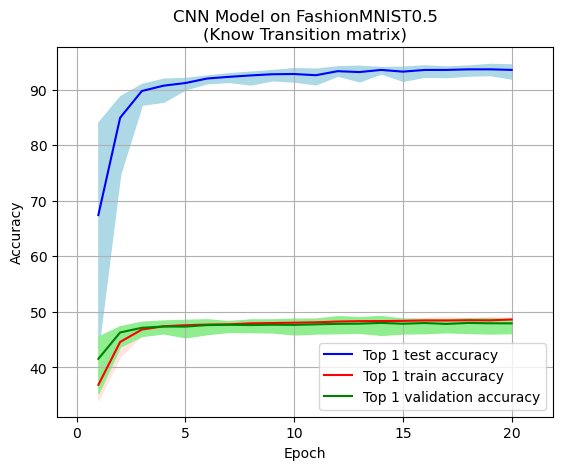

In [20]:
CNN_t_M5_sublists = [CNN_test_acc_m5[i:i+20] for i in range(0, len(CNN_test_acc_m5), 20)]
CNN_tr_M5_sublists = [CNN_train_acc_m5[i:i+20] for i in range(0, len(CNN_train_acc_m5), 20)]
CNN_v_M5_sublists = [CNN_validat_acc_m5[i:i+20] for i in range(0, len(CNN_validat_acc_m5), 20)]

test_data_array = np.array(CNN_t_M5_sublists)
train_data_array = np.array(CNN_tr_M5_sublists)
val_data_array = np.array(CNN_v_M5_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model on FashionMNIST0.5\n(Know Transition matrix)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Reweighting/CNN Model on FashionMNIST0.5 (Know Transition matrix).png', dpi=300)
plt.show()

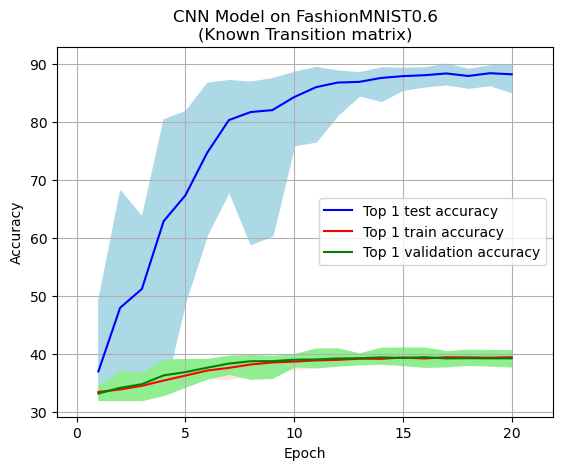

In [21]:
CNN_t_M6_sublists = [CNN_test_acc_m6[i:i+20] for i in range(0, len(CNN_test_acc_m6), 20)]
CNN_tr_M6_sublists = [CNN_train_acc_m6[i:i+20] for i in range(0, len(CNN_train_acc_m6), 20)]
CNN_v_M6_sublists = [CNN_validat_acc_m6[i:i+20] for i in range(0, len(CNN_validat_acc_m6), 20)]

test_data_array = np.array(CNN_t_M6_sublists)
train_data_array = np.array(CNN_tr_M6_sublists)
val_data_array = np.array(CNN_v_M6_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model on FashionMNIST0.6\n(Known Transition matrix)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Reweighting/CNN Model on FashionMNIST0.6 (Know Transition matrix).png', dpi=300)
plt.show()

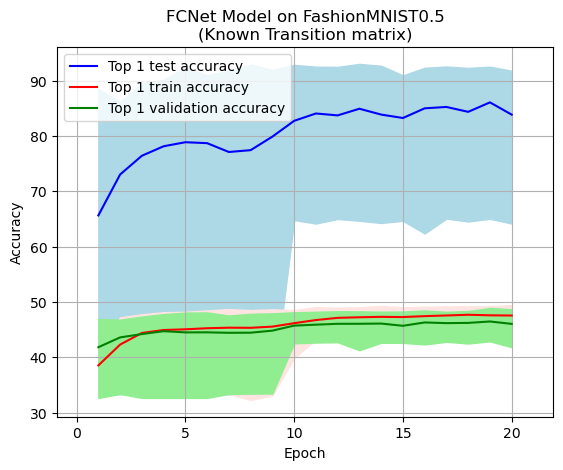

In [22]:
FCNet_t_M5_sublists = [FCNet_test_acc_m5[i:i+20] for i in range(0, len(FCNet_test_acc_m5), 20)]
FCNet_tr_M5_sublists = [FCNet_train_acc_m5[i:i+20] for i in range(0, len(FCNet_train_acc_m5), 20)]
FCNet_v_M5_sublists = [FCNet_validat_acc_m5[i:i+20] for i in range(0, len(FCNet_validat_acc_m5), 20)]

test_data_array = np.array(FCNet_t_M5_sublists)
train_data_array = np.array(FCNet_tr_M5_sublists)
val_data_array = np.array(FCNet_v_M5_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FCNet Model on FashionMNIST0.5\n(Known Transition matrix)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Reweighting/FCNet Model on FashionMNIST0.5 (Know Transition matrix).png', dpi=300)
plt.show()

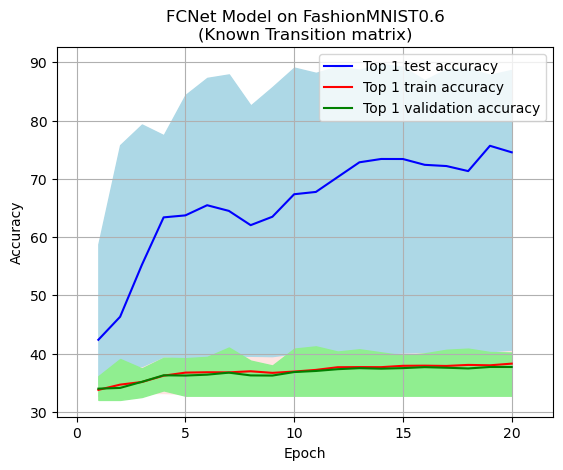

In [23]:
FCNet_t_M6_sublists = [FCNet_test_acc_m6[i:i+20] for i in range(0, len(FCNet_test_acc_m6), 20)]
FCNet_tr_M6_sublists = [FCNet_train_acc_m6[i:i+20] for i in range(0, len(FCNet_train_acc_m6), 20)]
FCNet_v_M6_sublists = [FCNet_validat_acc_m6[i:i+20] for i in range(0, len(FCNet_validat_acc_m6), 20)]

test_data_array = np.array(FCNet_t_M6_sublists)
train_data_array = np.array(FCNet_tr_M6_sublists)
val_data_array = np.array(FCNet_v_M6_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FCNet Model on FashionMNIST0.6\n(Known Transition matrix)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Reweighting/FCNet Model on FashionMNIST0.6 (Know Transition matrix).png', dpi=300)
plt.show()

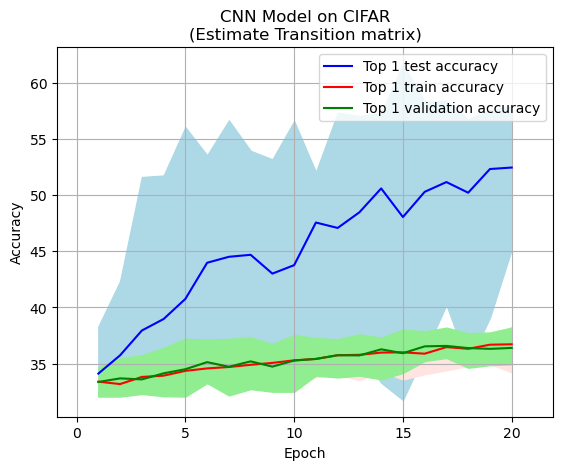

In [24]:
CNN_t_c_sublists = [CNN_test_acc_c[i:i+20] for i in range(0, len(CNN_test_acc_c), 20)]
CNN_tr_c_sublists = [CNN_train_acc_c[i:i+20] for i in range(0, len(CNN_train_acc_c), 20)]
CNN_v_c_sublists = [CNN_validat_acc_c[i:i+20] for i in range(0, len(CNN_validat_acc_c), 20)]

test_data_array = np.array(CNN_t_c_sublists)
train_data_array = np.array(CNN_tr_c_sublists)
val_data_array = np.array(CNN_v_c_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model on CIFAR\n(Estimate Transition matrix)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Reweighting/CNN Model on CIFAR (Estimate Transition matrix).png', dpi=300)
plt.show()

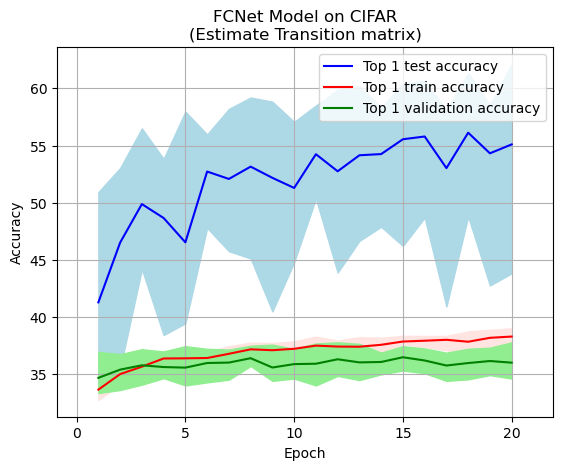

In [25]:
FCNet_t_c_sublists = [FCNet_test_acc_c[i:i+20] for i in range(0, len(FCNet_test_acc_c), 20)]
FCNet_tr_c_sublists = [FCNet_train_acc_c[i:i+20] for i in range(0, len(FCNet_train_acc_c), 20)]
FCNet_v_c_sublists = [FCNet_validat_acc_c[i:i+20] for i in range(0, len(FCNet_validat_acc_c), 20)]

test_data_array = np.array(FCNet_t_c_sublists)
train_data_array = np.array(FCNet_tr_c_sublists)
val_data_array = np.array(FCNet_v_c_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FCNet Model on CIFAR\n(Estimate Transition matrix)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Reweighting/FCNet Model on CIFAR (Estimate Transition matrix).png', dpi=300)
plt.show()

## Unbiased estimator

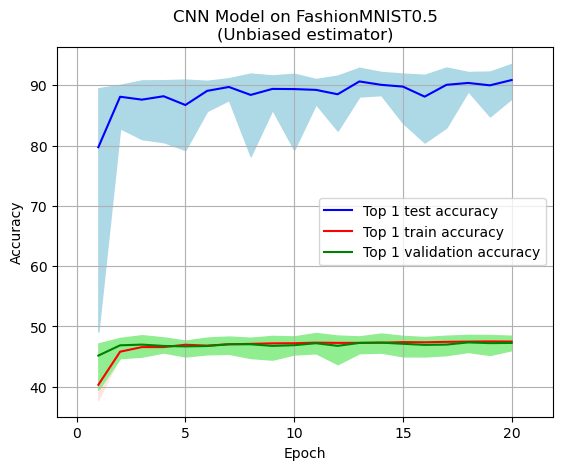

In [26]:
uCNN_t_M5_sublists = [uCNN_test_acc_m5[i:i+20] for i in range(0, len(uCNN_test_acc_m5), 20)]
uCNN_tr_M5_sublists = [uCNN_train_acc_m5[i:i+20] for i in range(0, len(uCNN_train_acc_m5), 20)]
uCNN_v_M5_sublists = [uCNN_validat_acc_m5[i:i+20] for i in range(0, len(uCNN_validat_acc_m5), 20)]

test_data_array = np.array(uCNN_t_M5_sublists)
train_data_array = np.array(uCNN_tr_M5_sublists)
val_data_array = np.array(uCNN_v_M5_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model on FashionMNIST0.5\n(Unbiased estimator)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Unbiased estimator/CNN Model on FashionMNIST0.5 (Unbiased estimator).png', dpi=300)
plt.show()

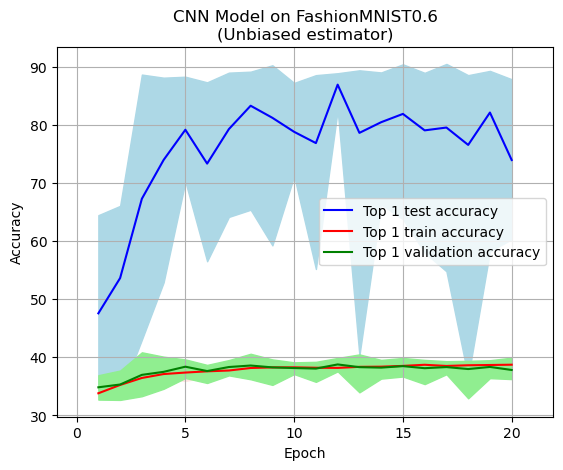

In [27]:
uCNN_t_M6_sublists = [uCNN_test_acc_m6[i:i+20] for i in range(0, len(uCNN_test_acc_m6), 20)]
uCNN_tr_M6_sublists = [uCNN_train_acc_m6[i:i+20] for i in range(0, len(uCNN_train_acc_m6), 20)]
uCNN_v_M6_sublists = [uCNN_validat_acc_m6[i:i+20] for i in range(0, len(uCNN_validat_acc_m6), 20)]

test_data_array = np.array(uCNN_t_M6_sublists)
train_data_array = np.array(uCNN_tr_M6_sublists)
val_data_array = np.array(uCNN_v_M6_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model on FashionMNIST0.6\n(Unbiased estimator)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Unbiased estimator/CNN Model on FashionMNIST0.6 (Unbiased estimator).png', dpi=300)
plt.show()

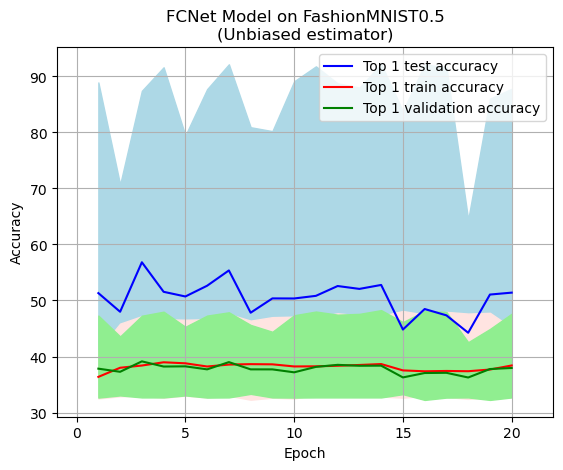

In [28]:
uFCNet_t_M5_sublists = [uFCNet_test_acc_m5[i:i+20] for i in range(0, len(uFCNet_test_acc_m5), 20)]
uFCNet_tr_M5_sublists = [uFCNet_train_acc_m5[i:i+20] for i in range(0, len(uFCNet_train_acc_m5), 20)]
uFCNet_v_M5_sublists = [uFCNet_validat_acc_m5[i:i+20] for i in range(0, len(uFCNet_validat_acc_m5), 20)]

test_data_array = np.array(uFCNet_t_M5_sublists)
train_data_array = np.array(uFCNet_tr_M5_sublists)
val_data_array = np.array(uFCNet_v_M5_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FCNet Model on FashionMNIST0.5\n(Unbiased estimator)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Unbiased estimator/FCNet Model on FashionMNIST0.5 (Unbiased estimator).png', dpi=300)
plt.show()

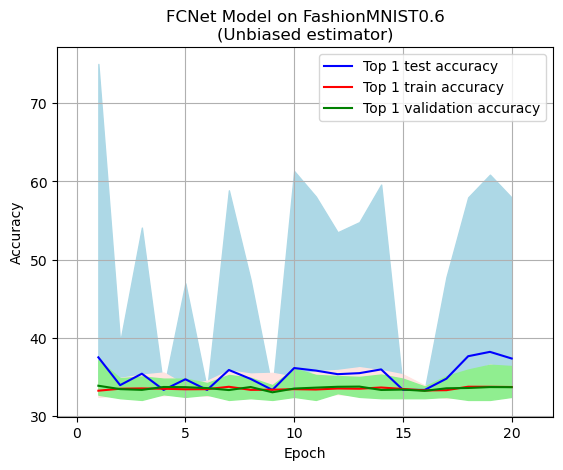

In [29]:
uFCNet_t_M6_sublists = [uFCNet_test_acc_m6[i:i+20] for i in range(0, len(uFCNet_test_acc_m6), 20)]
uFCNet_tr_M6_sublists = [uFCNet_train_acc_m6[i:i+20] for i in range(0, len(uFCNet_train_acc_m6), 20)]
uFCNet_v_M6_sublists = [uFCNet_validat_acc_m6[i:i+20] for i in range(0, len(uFCNet_validat_acc_m6), 20)]

test_data_array = np.array(uFCNet_t_M6_sublists)
train_data_array = np.array(uFCNet_tr_M6_sublists)
val_data_array = np.array(uFCNet_v_M6_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FCNet Model on FashionMNIST0.6\n(Unbiased estimator)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Unbiased estimator/FCNet Model on FashionMNIST0.6 (Unbiased estimator).png', dpi=300)
plt.show()

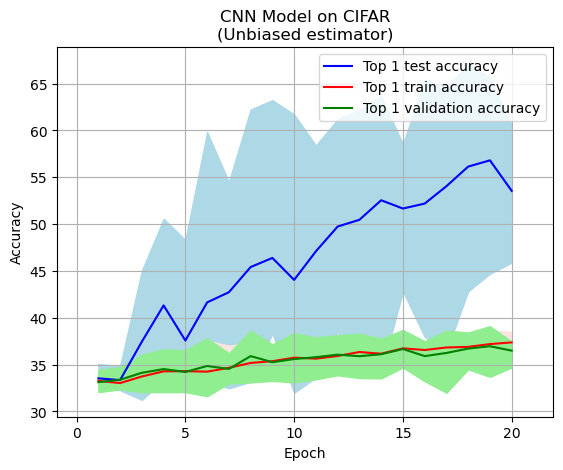

In [30]:
uCNN_t_c_sublists = [uCNN_test_acc_c[i:i+20] for i in range(0, len(uCNN_test_acc_c), 20)]
uCNN_tr_c_sublists = [uCNN_train_acc_c[i:i+20] for i in range(0, len(uCNN_train_acc_c), 20)]
uCNN_v_c_sublists = [uCNN_validat_acc_c[i:i+20] for i in range(0, len(uCNN_validat_acc_c), 20)]

test_data_array = np.array(uCNN_t_c_sublists)
train_data_array = np.array(uCNN_tr_c_sublists)
val_data_array = np.array(uCNN_v_c_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Model on CIFAR\n(Unbiased estimator)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Unbiased estimator/CNN Model on CIFAR (Unbiased estimator).png', dpi=300)
plt.show()

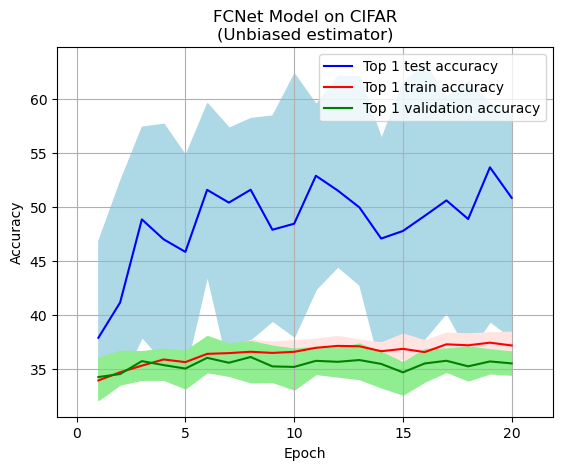

In [31]:
uFCNet_t_c_sublists = [uFCNet_test_acc_c[i:i+20] for i in range(0, len(uFCNet_test_acc_c), 20)]
uFCNet_tr_c_sublists = [uFCNet_train_acc_c[i:i+20] for i in range(0, len(uFCNet_train_acc_c), 20)]
uFCNet_v_c_sublists = [uFCNet_validat_acc_c[i:i+20] for i in range(0, len(uFCNet_validat_acc_c), 20)]

test_data_array = np.array(uFCNet_t_c_sublists)
train_data_array = np.array(uFCNet_tr_c_sublists)
val_data_array = np.array(uFCNet_v_c_sublists)

test_upper_limit = test_data_array.max(axis=0)
test_lower_limit = test_data_array.min(axis=0)

train_upper_limit = train_data_array.max(axis=0)
train_lower_limit = train_data_array.min(axis=0)

val_uper_limit = val_data_array.max(axis=0)
val_lower_limit = val_data_array.min(axis=0)

x = range(1, 21)

plt.plot(x, test_data_array.mean(axis=0), color='blue', label='Top 1 test accuracy')
plt.plot(x, train_data_array.mean(axis=0), color='red', label='Top 1 train accuracy')
plt.plot(x, val_data_array.mean(axis=0), color='green', label='Top 1 validation accuracy')
plt.fill_between(x, test_lower_limit, test_upper_limit, color='lightblue')
plt.fill_between(x, train_lower_limit, train_upper_limit, color='mistyrose')
plt.fill_between(x, val_lower_limit, val_uper_limit, color='lightgreen')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('FCNet Model on CIFAR\n(Unbiased estimator)')
plt.legend()
plt.margins(x=0.1)
plt.grid(True)
plt.savefig('Picture/Unbiased estimator/FCNet Model on CIFAR (Unbiased estimator).png', dpi=300)
plt.show()